In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, lit, when, exp, radians, cos, sin, mean, avg, max as spark_max, min as spark_min,
    sum as spark_sum, lag
)
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.sql.functions import year
import matplotlib.pyplot as plt
from pyspark.sql.functions import count, desc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [3]:
# Initialize Spark session
spark = SparkSession.builder.appName("wildfire project").getOrCreate()

# Path to the data directory (do not specify a file name, just the directory)
data_dir = "/content/data"

# Load all CSV files in the directory
df = spark.read.csv(data_dir, header=True, inferSchema=True).cache()

# df.show(10)



In [11]:
 df.printSchema()

root
 |-- date: date (nullable = true)
 |-- city: string (nullable = true)
 |-- weather_latitude: double (nullable = true)
 |-- weather_longitude: double (nullable = true)
 |-- temperature_2m_max: double (nullable = true)
 |-- temperature_2m_min: double (nullable = true)
 |-- temperature_2m_mean: double (nullable = true)
 |-- apparent_temperature_max: double (nullable = true)
 |-- apparent_temperature_min: double (nullable = true)
 |-- apparent_temperature_mean: double (nullable = true)
 |-- daylight_duration: double (nullable = true)
 |-- sunshine_duration: double (nullable = true)
 |-- precipitation_sum: double (nullable = true)
 |-- rain_sum: double (nullable = true)
 |-- snowfall_sum: double (nullable = true)
 |-- precipitation_hours: double (nullable = true)
 |-- wind_speed_10m_max: double (nullable = true)
 |-- wind_gusts_10m_max: double (nullable = true)
 |-- wind_direction_10m_dominant: double (nullable = true)
 |-- shortwave_radiation_sum: double (nullable = true)
 |-- et0_fao

In [4]:
df.summary().show()

+-------+-------------+------------------+-------------------+------------------+------------------+-------------------+------------------------+------------------------+-------------------------+------------------+------------------+-----------------+------------------+------------------+-------------------+------------------+------------------+---------------------------+-----------------------+--------------------------+------------------+------------------+------------------+------------------+------------------+---------+----------+-----------------+------------------+------------------+------------------+--------+--------------------+---------------------+---------------------+----------------------------+------------------+------------------+---------------------+-------------------+-------------------+------------------+-------------------+--------------------------+
|summary|         city|  weather_latitude|  weather_longitude|temperature_2m_max|temperature_2m_min|temperature_

In [5]:
from pyspark.sql.functions import when

df = df.withColumn("wildfire", when(col("instrument") == "MODIS", 1).otherwise(0))

In [10]:
df.summary().show()

+-------+-------------+------------------+-------------------+------------------+------------------+-------------------+------------------------+------------------------+-------------------------+------------------+------------------+-----------------+------------------+------------------+-------------------+------------------+------------------+---------------------------+-----------------------+--------------------------+------------------+------------------+------------------+------------------+------------------+---------+----------+-----------------+------------------+------------------+------------------+--------+--------------------+---------------------+---------------------+----------------------------+------------------+------------------+---------------------+-------------------+-------------------+------------------+-------------------+--------------------------+------------------+
|summary|         city|  weather_latitude|  weather_longitude|temperature_2m_max|temperature_

# Wildfires Trend Over Time

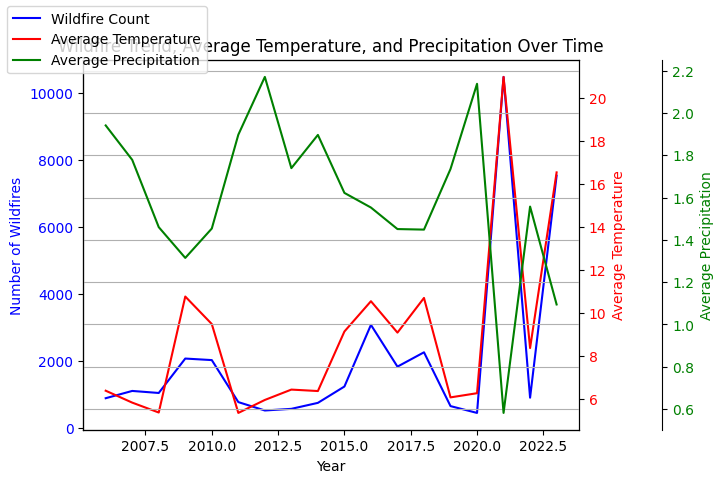

In [25]:
wildfires = df.filter(col("wildfire") == 1)


wildfires_with_year = wildfires.withColumn("year", year(col("date")))
wildfire_trend = wildfires_with_year.groupBy("year").count().orderBy("year")
# Calculate average temperature per year using 'temperature_2m_mean'
avg_temp_per_year = df.groupBy(year(col("date")).alias("year")) \
    .agg(avg("temperature_2m_mean").alias("avg_temperature")) \
    .orderBy("year")

# Calculate average precipitation per year
avg_precip_per_year = df.groupBy(year(col("date")).alias("year")) \
    .agg(avg("precipitation_sum").alias("avg_precipitation")) \
    .orderBy("year")


# Convert all DataFrames to Pandas for plotting
wildfire_trend_pd = wildfire_trend.toPandas()
avg_temp_pd = avg_temp_per_year.toPandas()
avg_precip_pd = avg_precip_per_year.toPandas()  # Convert to Pandas

# Create the plot with three y-axes (one for each variable)
fig, ax1 = plt.subplots()

# Plot wildfire trend on the first y-axis
ax1.plot(wildfire_trend_pd["year"], wildfire_trend_pd["count"], color="blue", label="Wildfire Count")
ax1.set_xlabel("Year")
ax1.set_ylabel("Number of Wildfires", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Create a second y-axis for average temperature
ax2 = ax1.twinx()
ax2.plot(avg_temp_pd["year"], avg_temp_pd["avg_temperature"], color="red", label="Average Temperature")
ax2.set_ylabel("Average Temperature", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Create a third y-axis for average precipitation
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis spine
ax3.plot(avg_precip_pd["year"], avg_precip_pd["avg_precipitation"], color="green", label="Average Precipitation")
ax3.set_ylabel("Average Precipitation", color="green")
ax3.tick_params(axis="y", labelcolor="green")

# Add title, legend, and grid
plt.title("Wildfire Trend, Average Temperature, and Precipitation Over Time")
fig.legend(loc="upper left")
plt.grid(True)

# Display the plot
plt.show()

This chart visualizes the relationship between wildfire count, average temperature, and average precipitation over time. Key observations include the correlation between temperature, precipitation, and wildfire activity. The blue line represents wildfire count, the red line indicates average temperature, and the green line corresponds to average precipitation.

In years with higher average temperatures, such as 2016 and 2021, there is a noticeable increase in wildfire count, suggesting a potential link between temperature and wildfire activity. Conversely, years with higher average precipitation generally show lower wildfire counts, indicating precipitation may act as a mitigating factor for wildfires. The interplay between these variables highlights how climatic factors like temperature and precipitation contribute to wildfire dynamics, underscoring the importance of understanding environmental influences for better wildfire management.

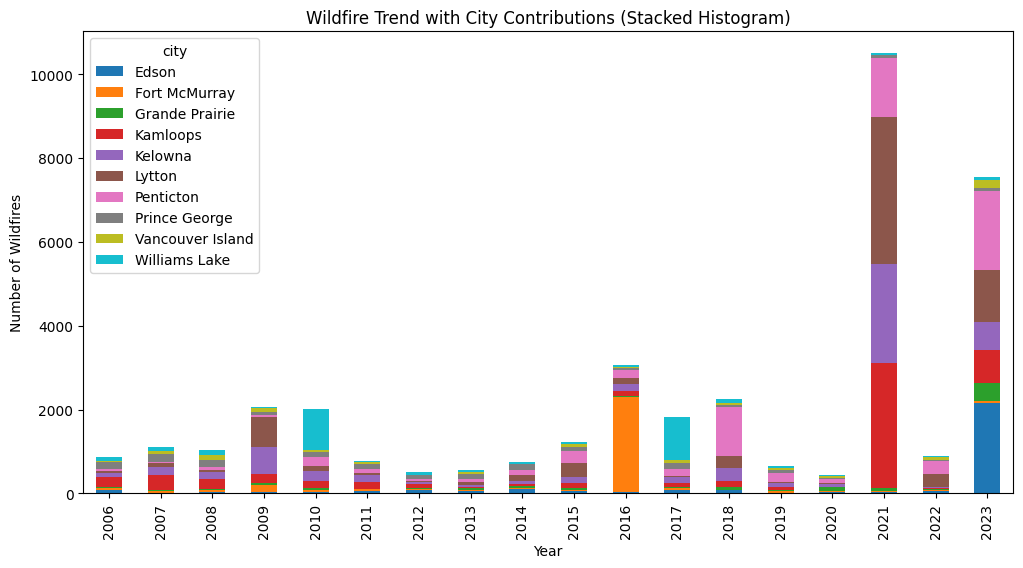

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' DataFrame with 'city', 'date', and 'wildfire' columns

# Filter for wildfire occurrences (wildfire == 1)
wildfires = df.filter(col("wildfire") == 1)

# Extract year and city from the DataFrame
wildfires_with_year_city = wildfires.withColumn("year", year(col("date")))

# Group by year and city, and count occurrences
wildfire_counts = wildfires_with_year_city.groupBy("year", "city") \
    .agg(count("*").alias("wildfire_count")) \
    .orderBy("year", "city")

# Convert to Pandas DataFrame for plotting
wildfire_counts_pd = wildfire_counts.toPandas()

# Pivot the DataFrame to create a suitable format for stacked histogram
wildfire_counts_pivot = wildfire_counts_pd.pivot(index='year', columns='city', values='wildfire_count')

# Create the stacked histogram
wildfire_counts_pivot.plot(kind='bar', stacked=True, figsize=(12, 6))

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Days of Wildfires')
plt.title('Wildfire Trend with City Contributions (Stacked Histogram)')

# Display the plot
plt.show()

This stacked histogram illustrates the annual wildfire trends across various cities from 2006 to 2022, highlighting notable fluctuations over the years. While the overall number of wildfires varies, significant spikes are evident in 2009, 2016, and 2021. The contributions from different cities also vary, with some playing a larger role during peak years. For instance, in 2016, Fort McMurray shows a dramatic increase, likely tied to a major wildfire event, while 2021 exhibits an unprecedented surge, with substantial contributions from cities like Lytton and Kamloops. Conversely, years such as 2012, 2013, and 2014 demonstrate relative stability, with fewer wildfires and less variation among cities.

City-specific contributions reveal consistent trends for some locations, such as Vancouver Island, Williams Lake, and Prince George, which contribute smaller but steady portions to the total. However, the sharp increases in specific years suggest the influence of significant climate events, extreme weather patterns, or human activities. The stark rise in 2021 may correlate with increased wildfire risks due to rising temperatures or prolonged drought conditions. This data provides valuable insight into the regional and temporal dynamics of wildfires, underscoring the need for targeted wildfire prevention and management strategies.

# 2020 to 2021, A Giantic Increase In The Number of Days of Wildfires.

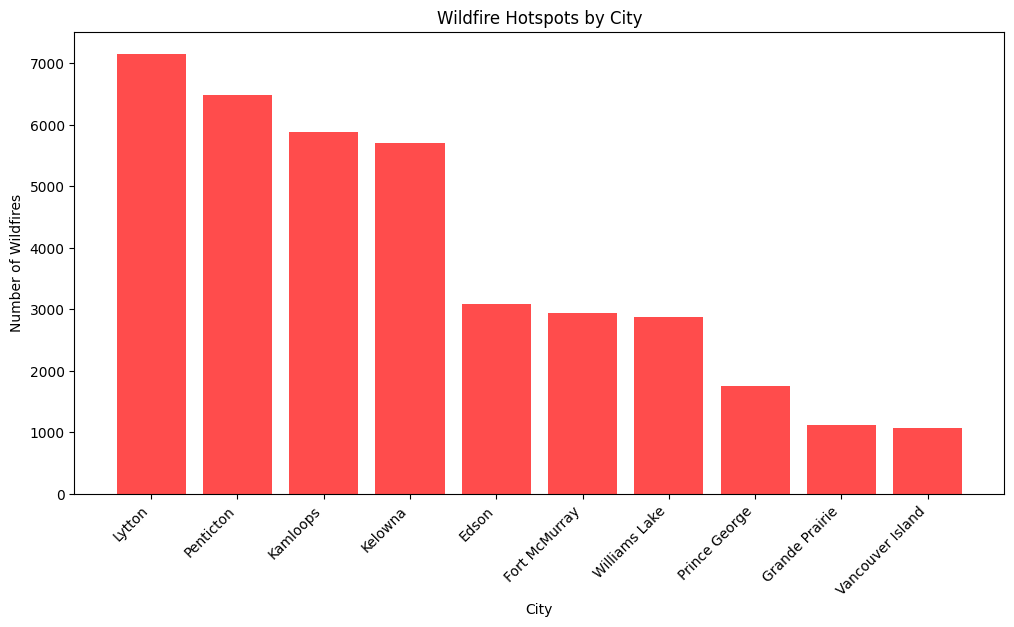

In [7]:
import matplotlib.pyplot as plt

# Assuming 'df' DataFrame with a 'city' column

# Filter for wildfire occurrences (wildfire == 1)
wildfires = df.filter(col("wildfire") == 1)

# Group by city and count occurrences
hotspots_by_city = wildfires.groupBy("city") \
    .agg(count("*").alias("wildfire_count")) \
    .orderBy(desc("wildfire_count"))

# Convert Spark DataFrame to Pandas DataFrame for plotting
hotspots_by_city_pd = hotspots_by_city.toPandas()

# Create the bar plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.bar(hotspots_by_city_pd['city'], hotspots_by_city_pd['wildfire_count'],
        color='red', alpha=0.7)

# Add labels and title
plt.xlabel('City')
plt.ylabel('Number of Wildfires')
plt.title('Wildfire Hotspots by City')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.show()

The bar graph titled "Wildfire Hotspots by City" shows the number of wildfires recorded across ten different cities, with Lytton leading significantly at approximately 7,000 wildfires. Following Lytton are Penticton, Kamloops, and Kelowna, each recording between 5,500 and 6,500 wildfires. These four cities appear to be the major wildfire hotspots among those measured, with substantially higher numbers than the other locations. The remaining cities show a marked decrease in wildfire frequency, with Edson, Fort McMurray, and Williams Lake each recording around 3,000 wildfires. The graph concludes with Prince George, Grande Prairie, and Vancouver Island showing the lowest numbers, each with fewer than 2,000 wildfires. This data suggests a significant geographic disparity in wildfire occurrence, with certain cities facing considerably higher fire risks than others. Most of these cities appear to be in western Canada, particularly in British Columbia and Alberta, regions known for their susceptibility to forest fires.

In [6]:
from pyspark.sql.functions import year, avg, when, sum as spark_sum

# Filter for the specified cities and years
filtered_df = df.filter(
    (col("city").isin(["Penticton", "Lytton", "Kelowna", "Kamloops"])) &
    (year(col("date")).isin([2020, 2021]))
)

# Group by city, year, and calculate average values for features
city_year_features = filtered_df.groupBy("city", year(col("date")).alias("year")) \
    .agg(
        avg("temperature_2m_mean").alias("avg_temperature"),
        avg("new_dryness_index").alias("avg_dryness_index"),
        avg("precipitation_sum").alias("avg_precipitation"),
        avg("sunshine_duration").alias("avg_sunshine"),  # Corrected column name
        avg("daylight_duration").alias("avg_daylight"),
        avg("et0_fao_evapotranspiration").alias("avg_et0_fao_evapotranspiration"),
        avg("new_relative_humidity").alias("avg_relative_humidity_2m"),
        # Add other features you want to compare here
    ) \
    .orderBy("city", "year")

# Pivot the table for easier comparison
features_pivot = city_year_features.groupBy("city") \
    .pivot("year", [2020, 2021]) \
    .agg(
        # Select the average values for each feature
        # Use the appropriate aggregation function if needed (e.g., spark_sum, spark_max)
        avg("avg_temperature").alias("avg_temperature"),
        avg("avg_dryness_index").alias("avg_dryness_index"),
        avg("avg_precipitation").alias("avg_precipitation"),
        avg("avg_sunshine").alias("avg_sunshine"),  # Corrected column name
        avg("avg_daylight").alias("avg_daylight"),
        avg("avg_et0_fao_evapotranspiration").alias("avg_et0_fao_evapotranspiration"),
        avg("avg_relative_humidity_2m").alias("avg_relative_humidity_2m"),
        # Add other features and aggregation functions here
    ) \
    .orderBy("city")

# Show the comparison table
features_pivot.show()

+---------+--------------------+----------------------+----------------------+------------------+------------------+-----------------------------------+-----------------------------+--------------------+----------------------+----------------------+-----------------+------------------+-----------------------------------+-----------------------------+
|     city|2020_avg_temperature|2020_avg_dryness_index|2020_avg_precipitation| 2020_avg_sunshine| 2020_avg_daylight|2020_avg_et0_fao_evapotranspiration|2020_avg_relative_humidity_2m|2021_avg_temperature|2021_avg_dryness_index|2021_avg_precipitation|2021_avg_sunshine| 2021_avg_daylight|2021_avg_et0_fao_evapotranspiration|2021_avg_relative_humidity_2m|
+---------+--------------------+----------------------+----------------------+------------------+------------------+-----------------------------------+-----------------------------+--------------------+----------------------+----------------------+-----------------+------------------+--------

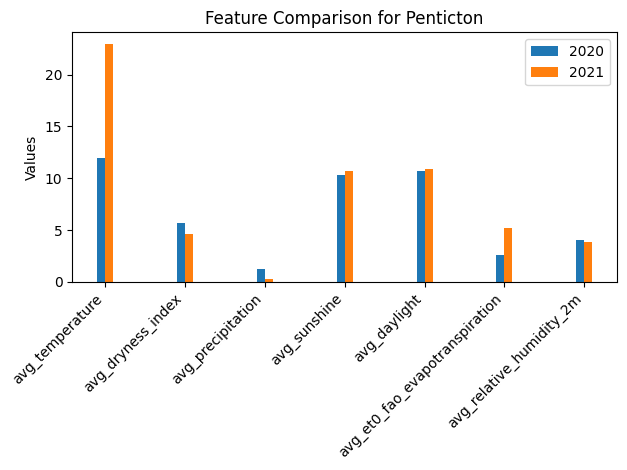

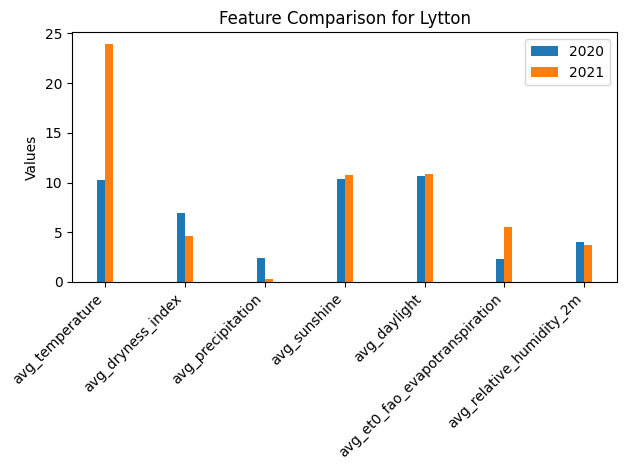

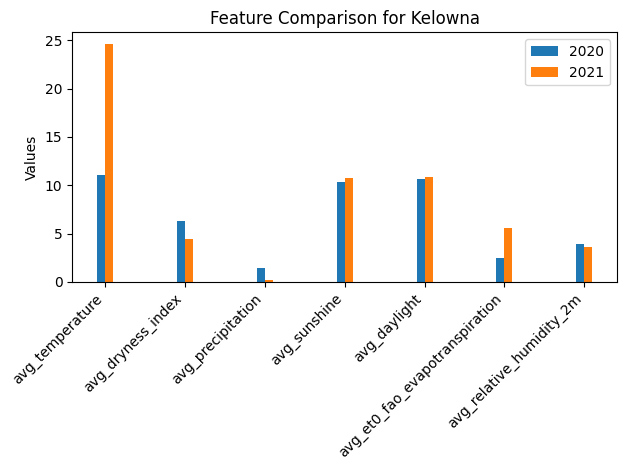

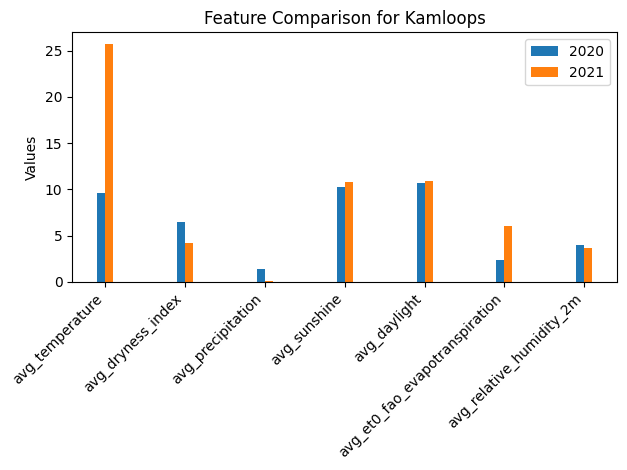

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler


# List of cities
cities = ["Penticton", "Lytton", "Kelowna", "Kamloops"]

# List of features to compare (without year prefix)
features = ['avg_temperature', 'avg_dryness_index', 'avg_precipitation', 'avg_sunshine',
            'avg_daylight', 'avg_et0_fao_evapotranspiration', 'avg_relative_humidity_2m']

# Create a figure and axes for each city
for city in cities:
    city_data = features_pivot_pd[features_pivot_pd['city'] == city]

    # Extract data for 2020 and 2021
    values_2020 = city_data[[f'2020_{feature}' for feature in features]].values.flatten()
    values_2021 = city_data[[f'2021_{feature}' for feature in features]].values.flatten()

    # Apply log transformation to sunshine, daylight, and relative humidity
    sunshine_index = features.index('avg_sunshine')
    daylight_index = features.index('avg_daylight')
    humidity_index = features.index('avg_relative_humidity_2m')  # Get index of humidity

    values_2020[sunshine_index] = np.log1p(values_2020[sunshine_index])
    values_2020[daylight_index] = np.log1p(values_2020[daylight_index])
    values_2020[humidity_index] = np.log1p(values_2020[humidity_index])  # Apply log to humidity

    values_2021[sunshine_index] = np.log1p(values_2021[sunshine_index])
    values_2021[daylight_index] = np.log1p(values_2021[daylight_index])
    values_2021[humidity_index] = np.log1p(values_2021[humidity_index])  # Apply log to humidity

    # print(values_2020)
    # print(values_2021)

    # Set up the bar positions
    x = np.arange(len(features))  # the label locations
    width = 0.1  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, values_2020, width, label='2020')
    rects2 = ax.bar(x + width/2, values_2021, width, label='2021')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Values')
    ax.set_title(f'Feature Comparison for {city}')
    ax.set_xticks(x)
    ax.set_xticklabels(features, rotation=45, ha='right')  # Rotate x-axis labels
    ax.legend()

    fig.tight_layout()
    plt.show()

This image presents a feature comparison for multiple cities (Penticton, Lytton, Kelowna, and Kamloops) between the years 2020 and 2021. Key environmental variables such as average temperature, dryness index, precipitation, sunshine, daylight, evapotranspiration, and relative humidity are plotted to observe differences across these years.

For all cities, average temperature and dryness index appear significantly higher in 2021 compared to 2020, which likely contributed to the increased wildfire activity in 2021. Other factors like average precipitation are noticeably lower in 2021, indicating drier conditions. Metrics such as sunshine and daylight hours remain relatively consistent across years, while evapotranspiration and relative humidity exhibit minor variations. These comparisons suggest that elevated temperatures and decreased precipitation were critical factors in the heightened wildfire risks observed in 2021.